# Формирование модели монетизации для мобильной игры «Космические братья»

## Цель и этапы исследования. Описание данных

**Цель исследования** — cформировать модель монетизации игрового приложения «Космические братья», рассчитать окупаемость рекламы при разных сценариях. Основная монетизация игры только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

**Этапы исследования**

1. Загрузка, первичный осмотр и предобработка данных.
2. Проведение исследовательского анализа данных. Изучим:
  - Период проведения исследования.
  - Динамику событий во времени.
  - Распределение пользователей по событиям.
  - Распределение построек по типам.
  - Среднее число сессий на пользователя.
  - Среднее время прохождения первого уровня.
3. Проведение маркетингового анализа данных. Изучим:
  - Период проведения рекламной кампании.
  - Распределение расходов по рекламным источникам.
  - Динамику расходов во времени по каждому источнику.
  - Распределение пользователей по рекламным источникам.
  - Cтоимость привлечения одного пользователя из каждого источника (CAC).
4. Формирование модели монетизации.
5. Проверка статистических гипотез.
  - Гипотеза различия среднего времени прохождения уровня игроками PvP и игроками PvE.
  - Гипотеза различия среднего количества построенных зданий у игроков PvP и игроков PvE.
6. Общий вывод.

**Описание данных**

В нашем распоряжении основной датасет `game_actions.csv` с данными о событиях, совершённых в игре. В ней пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики. В датасете содержатся данные первых пользователей приложения — когорты пользователей, которые начали пользоваться приложением в период с 4 по 10 мая включительно. В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом.
- Реализация проекта — разработка орбитальной сборки спутников.

Помимо основного датасета есть два датасета с информацией о рекламных активностях: `ad_costs.csv` и `user_source.csv`.

Структура данных **`game_actions.csv`**:

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта.

Структура данных **`ad_costs.csv`**:

- `source` — источник трафика;
- `day` — день, в который был совершен клик по объявлению;
- `cost` — стоимость кликов.

Структура данных **`user_source.csv`**:

- `user_id` — идентификатор пользователя;
- `source` — источник, с которого пришёл пользователь, установивший приложение.

## Материалы

- [Презентация] (https://clck.ru/344nED)
- [Дашборд] (https://clck.ru/33ZDfV)

## Загрузка, первичный осмотр и предобработка данных

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# cчитаем данные из csv-файлов и сохраним в переменные
game_actions = pd.read_csv('/datasets/game_actions.csv')
ad_costs = pd.read_csv('/datasets/ad_costs.csv')
user_source = pd.read_csv('/datasets/user_source.csv')

In [3]:
# напишем функцию для ознакомления с данными
def hello(df):
    print()
    print('Первые пять строк датафрейма:')
    print('--------------')
    display(df.head())   
    print()

    print('Основная информация:')
    print('--------------')
    df.info()
    print()

    print('Доля пропусков в данных:')
    print('--------------')
    display(pd.DataFrame(df.isna().mean().to_frame(name='Пропуски')
        .query('Пропуски > 0')['Пропуски'])
        .style.background_gradient('coolwarm')
        .format({'Пропуски':'{:.1%}'}))    
    print()
    
    print('Количество явных дубликатов:', df.duplicated().sum())
    print('Доля явных дубликатов: {:.2%}'.format(df.duplicated().sum() / len(df) * 100))
    # если явные дубликаты присутствуют, удалим их
    df_clean = df.drop_duplicates(inplace=True)
    print('Количество явных дубликатов после обработки:', df.duplicated().sum())
    print('Новое количество строк в датафрейме:', len(df))
    print('--------------')

### Изучение и обработка датафрейма `game_actions`

In [4]:
# применим к датафрейму game_actions функцию hello
hello(game_actions)


Первые пять строк датафрейма:
--------------


,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN



Основная информация:
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB

Доля пропусков в данных:
--------------


,Пропуски
building_type,5.7%
project_type,98.6%



Количество явных дубликатов: 1
Доля явных дубликатов: 0.07%
Количество явных дубликатов после обработки: 0
Новое количество строк в датафрейме: 135639
--------------


In [5]:
# переведём строковые значения колонки 'event_datetime' в формат даты и времени
game_actions['event_datetime'] = (
    pd.to_datetime(game_actions['event_datetime'], format='%Y-%m-%d %H:%M:%S')
)
# проверим результат
game_actions.dtypes['event_datetime'].name

'datetime64[ns]'

In [6]:
# выведем уникальные названия событий
game_actions['event'].value_counts(ascending=False)

building            127956
finished_stage_1      5817
project               1866
Name: event, dtype: int64

In [7]:
# выведем уникальные названия типов зданий
game_actions['building_type'].value_counts(ascending=False)

spaceport          59325
assembly_shop      54494
research_center    14137
Name: building_type, dtype: int64

In [8]:
# убедимся, что пропуски действительно обусловлены механикой сбора информации,
# и в данных нет «плохих» записей, а именно — проект без типа проекта
print(
    'Событий по реализации проекта из колонки "event":',
    len(game_actions.query('event == "project"'))
)
print(
    'Разработок орбитальной сборки спутников из колонки "project_type":',
    len(game_actions.query('project_type == "satellite_orbital_assembly"'))
)
print(
    'Событий по реализации проекта c разработкой орбитальной сборки спутников:',
    len(game_actions.query(
        'event == "project" & project_type == "satellite_orbital_assembly"'))
)
print(
    'Событий по реализации проекта без разработки орбитальной сборки спутников:',
    len(game_actions.query(
        'event == "project" & project_type != "satellite_orbital_assembly"'))
)

Событий по реализации проекта из колонки "event": 1866
Разработок орбитальной сборки спутников из колонки "project_type": 1866
Событий по реализации проекта c разработкой орбитальной сборки спутников: 1866
Событий по реализации проекта без разработки орбитальной сборки спутников: 0


In [9]:
# убедимся, в данных нет «плохих» записей, а именно — постройки без типа постройки
print(
    'Построенных объектов "building" из колонки "event":',
    len(game_actions.query('event == "building"'))
)
print(
    'Коспопортов, сборочных цехов и исследовательских центров из колонки "building_type":',
    len(game_actions.query(
        'building_type == "spaceport"\
        or building_type == "assembly_shop"\
        or building_type == "research_center"'))
)
print(
    'Построенных объектов с типом здания:',
    len(game_actions.query(
        'event == "building" &\
        building_type == "spaceport"\
        or building_type == "assembly_shop"\
        or building_type == "research_center"'))
)
print(
    'Построенных объектов без типа здания:',
    len(game_actions.query(
        'event == "building" &\
        building_type != "spaceport"\
        & building_type != "assembly_shop"\
        & building_type != "research_center"'))
)

Построенных объектов "building" из колонки "event": 127956
Коспопортов, сборочных цехов и исследовательских центров из колонки "building_type": 127956
Построенных объектов с типом здания: 127956
Построенных объектов без типа здания: 0


In [10]:
# проверим на наличие неявных дубликатов по совпадению 'user_id' и 'event_datetime'
print(
    'Число неявных дубликатов по совпадению "user_id" и "event_datetime":',
    len(game_actions[
        game_actions.duplicated(subset=['user_id', 'event_datetime'], keep=False)])
)
# проверим на наличие неявных дубликатов по совпадению 'user_id' и событию 'finished_stage_1'
print(
    'Число неявных дубликатов по совпадению "user_id" и событию "finished_stage_1":',
    len(game_actions[
        (game_actions['event'] == 'finished_stage_1')
        & (game_actions.duplicated(subset=['user_id', 'event'], keep=False))])
)
# проверим на наличие неявных дубликатов по совпадению 'user_id' и событию 'project'
print(
    'Число неявных дубликатов по совпадению "user_id" и событию "project":',
    len(game_actions[
        (game_actions['event'] == 'project')
        & (game_actions.duplicated(subset=['user_id', 'event'], keep=False))])
)
# проверим на наличие неявных дубликатов по совпадению 'user_id' и типу реализованного проекта
print(
    'Число неявных дубликатов по совпадению "user_id" и типу реализованного проекта:',
    len(game_actions[
    (game_actions['project_type'] == 'satellite_orbital_assembly')
    & (game_actions.duplicated(subset=['user_id', 'project_type'], keep=False))])
)

Число неявных дубликатов по совпадению "user_id" и "event_datetime": 0
Число неявных дубликатов по совпадению "user_id" и событию "finished_stage_1": 0
Число неявных дубликатов по совпадению "user_id" и событию "project": 0
Число неявных дубликатов по совпадению "user_id" и типу реализованного проекта: 0


#### **Вывод**

1. В датафрейме `game_actions` 135 640 строк и 5 колонок.
2. Названия колонок соответствуют стилю `snake_case` и не требуют корректировок.
3. В колонке `event_datetime` строковые значения перевели в формат даты и времени. В остальных колонках типы данных соответствуют представленным значениям.
4. Познакомились с уникальными названиями в колонках и выяснили, что в данных:
- Три события:
  - объект построен — `building`,
  - первый уровень завершён — `finished_stage_1`,
  - реализация проекта — `project`.
- Три типа зданий:
  - космопорт — `spaceport`, 
  - сборочный цех — `assembly_shop`,
  - исследовательский центр — `research_center`.
5. В двух колонках имеются пропущенные значения, которые мы проверили и убедились, что они обусловлены механикой сбора данных.
  - В колонке `building_type` значения соответствуют только событию `building` (объект построен) из колонки `event`. Остальным событиям тип здания назначаться не может, отсюда и пропуски.
  - В колонке `project_type` значение `satellite_orbital_assembly` (разработка орбитальной сборки спутников) соответствует только событию `project` (реализация проекта) из колонки `event`. Остальным событиям тип проекта назначаться не может, отсюда и пропуски.
6. Обнаружили и удалили 1 явный дубликат. Неявные дубликаты не найдены.



### Изучение и обработка датафрейма `ad_costs`

In [11]:
# применим к датафрейму ad_costs функцию hello
hello(ad_costs)


Первые пять строк датафрейма:
--------------


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796



Основная информация:
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes

Доля пропусков в данных:
--------------


,Пропуски



Количество явных дубликатов: 0
Доля явных дубликатов: 0.00%
Количество явных дубликатов после обработки: 0
Новое количество строк в датафрейме: 28
--------------


In [12]:
# переведём строковые значения колонки 'day' в формат даты
ad_costs['day'] = pd.to_datetime(ad_costs['day'], format='%Y-%m-%d')

# проверим результат
ad_costs.dtypes['day'].name

'datetime64[ns]'

In [13]:
# выведем уникальные названия источников трафика
ad_costs['source'].unique()

array(['facebook_ads', 'instagram_new_adverts', 'yandex_direct',
       'youtube_channel_reklama'], dtype=object)

In [14]:
# оставим более короткие названия источников трафика
ad_costs['source'] = ad_costs['source'].apply(lambda x: x.split('_')[0])

# проверим результат
ad_costs['source'].unique()

array(['facebook', 'instagram', 'yandex', 'youtube'], dtype=object)

In [15]:
# проверим на наличие неявных дубликатов по совпадению 'source' и 'day'
print(
    'Число неявных дубликатов по совпадению "source" и "day":',
    len(ad_costs[
        ad_costs.duplicated(subset=['source', 'day'], keep=False)
        ])
)

Число неявных дубликатов по совпадению "source" и "day": 0


In [16]:
# посмотрим описательную статистику колонки 'cost'
ad_costs.describe().style.format('{:.0f}')

,cost
count,28
mean,272
std,287
min,23
25%,67
50%,160
75%,349
max,969


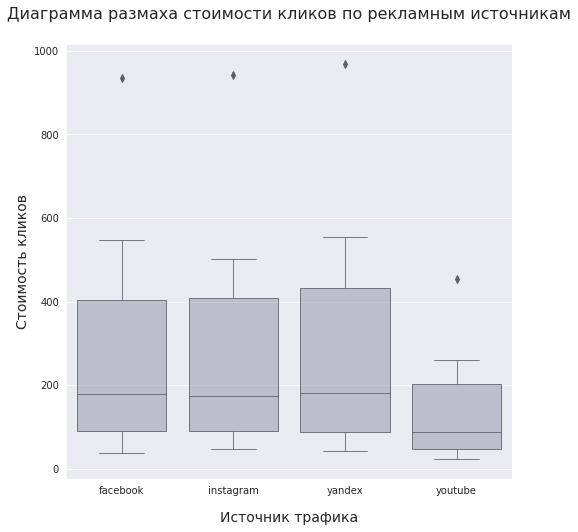

In [17]:
# визуально оценим характеристики распределения в колонке 'cost'
# построим диаграмму размаха
sns.set_style('darkgrid')
plt.figure(figsize=(8, 8))
ax = sns.boxplot(
    x='source',
    y='cost',
    data=ad_costs,
    color='#8c92ac',
    linewidth=0.8
)
# добавим заголовок и подписи к осям
plt.title(
    'Диаграмма размаха стоимости кликов по рекламным источникам',
    fontsize=16, pad=25
)
plt.xlabel('Источник трафика', fontsize=14, labelpad=15)
plt.ylabel('Cтоимость кликов', fontsize=14)

# добавим цветам прозрачности
for patch in ax.artists:
  r, g, b, a = patch.get_facecolor()
  patch.set_facecolor((r, g, b, .5))  

#### **Вывод**

1. В датафрейме `ad_costs` 28 строк и 3 колонки.
2. Пропуски и дубликаты не обнаружены.
3. Названия колонок соответствуют стилю `snake_case` и не требуют корректировок.
4. В колонке `day` строковые значения перевели в формат даты. В остальных колонках типы данных соответствуют представленным значениям.
5. Выяснили, что в данных четыре источника трафика: Facebook, Instagram, Yandex и Youtube. Заменили названия на более короткие.
6. По описательной статистике видим, средняя стоимость кликов по медиане равна 160 у.е., по среднему — 272 у.е. Минимальная стоимость кликов равна 23 у.е., максимальная — 969 у.е.

### Изучение и обработка датафрейма `user_source`

In [18]:
# применим к датафрейму user_source функцию hello
hello(user_source)


Первые пять строк датафрейма:
--------------


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads



Основная информация:
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB

Доля пропусков в данных:
--------------


,Пропуски



Количество явных дубликатов: 0
Доля явных дубликатов: 0.00%
Количество явных дубликатов после обработки: 0
Новое количество строк в датафрейме: 13576
--------------


In [19]:
# выведем уникальные названия источников трафика
user_source['source'].unique()

array(['facebook_ads', 'yandex_direct', 'youtube_channel_reklama',
       'instagram_new_adverts'], dtype=object)

In [20]:
# оставим более короткие названия источников трафика
user_source['source'] = user_source['source'].apply(lambda x: x.split('_')[0])

# проверим результат
user_source['source'].unique()

array(['facebook', 'yandex', 'youtube', 'instagram'], dtype=object)

#### **Вывод**

1. В датафрейме `user_source` 13 576 строк и 2 колонки.
2. Пропуски и дубликаты не обнаружены.
3. Названия колонок соответствуют стилю `snake_case` и не требуют корректировок.
4. Типы данных соответствуют представленным значениям.
5. Проверили и заменили названия источников трафика на более короткие.

### Категоризация данных и добавление нужных колонок

Выделим следующие категории пользователей:
- `winners_pve` — игроки, прошедшие первый уровень через реализацию проекта.
- `winners_pvp` — игроки, прошедшие первый уровень через победу над первым врагом.
- `losers` — игроки, не прошедшие первый уровень.

In [21]:
# список игроков, прошедших первый уровень
winners = list(game_actions.query('event == "finished_stage_1"')['user_id'].unique())

# список игроков, не прошедших первый уровень
losers = (
    list(game_actions[
        game_actions['user_id'].apply(lambda x: x not in winners)
        ]['user_id'].unique())
)
# cписок игроков, прошедших первый уровень через реализацию проекта
winners_pve = (
    list(game_actions[
        (game_actions['event'] == 'project') &
        (game_actions['user_id'].apply(lambda x: x in winners))
        ]['user_id'].unique())
)
# cписок всех игроков, прошедших первый уровень через победу над первым врагом
winners_pvp = (
    list(game_actions[
        game_actions['user_id'].apply(lambda x: x in winners) &
        game_actions['user_id'].apply(lambda x: x not in winners_pve)
        ]['user_id'].unique())
)
# проверим, что нет пользователей, которые попали в разные списки
print(
    'Пересечений losers и winners_pve:',
    len(set(losers).intersection(winners_pve))
)
print(
    'Пересечений losers и winners_pvp:',
    len(set(losers).intersection(winners_pvp))
)
print(
    'Пересечений winners_pve и winners_pvp:',
    len(set(winners_pve).intersection(winners_pvp))
)
# убедимся, что количество уникальных пользователей в трёх списках
# совпадает с количеством уникальных пользователей в исходном датафрейме
print(
    'Количество уникальных пользователей в трёх списках:',
    len(losers) + len(winners_pve) + len(winners_pvp)
)

Пересечений losers и winners_pve: 0
Пересечений losers и winners_pvp: 0
Пересечений winners_pve и winners_pvp: 0
Количество уникальных пользователей в трёх списках: 13576


In [22]:
# напишем функцию для распределения пользователей по категориям
def categorize_user(row):
  if row in losers:
    return 'losers'
  if row in winners_pve:
    return 'winner_pve'
  if row in winners_pvp:
    return 'winner_pvp'

# создадим новую колонку с категориями, применив функцию к колонке 'user_id'
game_actions['user_category'] = game_actions['user_id'].apply(categorize_user)

# проверим результат
game_actions.head()

,event_datetime,event,building_type,user_id,project_type,user_category
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,losers
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,winner_pve
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,winner_pvp
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,losers
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,winner_pvp


In [23]:
# убедимся, что число уникальных пользователей в датафрейме game_actions
# совпадает с числом уникальных пользователей в датафрейме user_source
print(
    'Количество уникальных пользователей в датафрейме "game_actions":',
    game_actions['user_id'].nunique()
)
print(
    'Количество уникальных пользователей в датафрейме "user_source":',
    user_source['user_id'].nunique()
)
print()
# добавим в основной датафрейм game_actions данные об источнике,
# с которого пришёл пользователь, установивший приложение
game_actions = game_actions.merge(user_source, on='user_id', how='left')

# проверим результат
game_actions.head()

Количество уникальных пользователей в датафрейме "game_actions": 13576
Количество уникальных пользователей в датафрейме "user_source": 13576



,event_datetime,event,building_type,user_id,project_type,user_category,source
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,losers,youtube
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,winner_pve,facebook
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,winner_pvp,instagram
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,losers,facebook
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,winner_pvp,yandex


In [24]:
# выделим в отдельные колонки дату и номер недели
game_actions['date'] = game_actions['event_datetime'].dt.date
game_actions['week'] = game_actions['event_datetime'].dt.week

# сохраним и скачаем полученный датафрейм
game_actions.to_csv('game_actions_merge.csv')

# проверим результат
game_actions.head()

,event_datetime,event,building_type,user_id,project_type,user_category,source,date,week
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,losers,youtube,2020-05-04,19
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,winner_pve,facebook,2020-05-04,19
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,winner_pvp,instagram,2020-05-04,19
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,losers,facebook,2020-05-04,19
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,winner_pvp,yandex,2020-05-04,19


#### **Вывод**

- Выделили три категории пользователей: игроков, не прошедших первый уровень, игроков PvP и игроков PvE.
- Добавили в основной датафрейм `game_actions` данные об источнике, с которого пришёл пользователь, установивший приложение.
- Создали отдельные колонки с датой и номером недели.

## Проведение исследовательского анализа данных

### Период проведения исследования

In [25]:
# посмотрим период проведения исследования
print('Минимальная дата события:', game_actions['event_datetime'].min())
print('Максимальная дата события:', game_actions['event_datetime'].max())
print(
    'Количество дней исследования:',
    game_actions['event_datetime'].max() - game_actions['event_datetime'].min()
)

Минимальная дата события: 2020-05-04 00:00:01
Максимальная дата события: 2020-06-05 12:32:49
Количество дней исследования: 32 days 12:32:48


#### **Вывод**

Период проведения исследования составляет 32 дня — с 4 мая по 5 июня 2020 года.

### Динамика событий во времени

In [26]:
# напишем функцию для просмотра динамики событий во времени
def event_by_date(event):
  event_by_date = (
      game_actions[game_actions['event'] == event]
      .groupby('date', as_index=False)['user_id'].count()
      .rename(columns={'user_id': 'event_cnt'})
      )
  # проверим результат
  print('\033[1m' + 'Количество событий {} в первые 5 дней'.format(event))
  print()
  display(event_by_date.head())
  print()
  print()
  print('\033[1m' + 'Количество событий {} в последние 5 дней'.format(event))
  print()
  display(event_by_date.tail())
  print()
  print()
  print(
      'Дата с максимальным количеством событий {}:'.format(event),
      event_by_date.loc[event_by_date['event_cnt'].idxmax()][0].strftime('%Y-%m-%d'),
      '(', event_by_date['event_cnt'].max(), 'события )'
      )
  print(
      'Дата с минимальным количеством событий {}:'.format(event),
      event_by_date.loc[event_by_date['event_cnt'].idxmin()][0].strftime('%Y-%m-%d'),
      '(', event_by_date['event_cnt'].min(), 'события )'
      )

In [27]:
# напишем функцию для построения столбиковой диаграммы с разделением по категориям
def event_by_date_barplot(event, color_1, color_2, color_3):
  plt.figure(figsize=(15, 8))
  data = (
      game_actions[game_actions['event'] == event]
      .groupby(['date', 'user_category'], as_index=False)['user_id'].count()
      .sort_values(by=['date', 'user_id'], ascending=True)
      )
  sns.barplot(
      x='date',
      y='user_id',
      hue='user_category',
      data=data,
      palette=[color_1, color_2, color_3]
      )
  # добавим легенду, заголовок и подписи к осям
  plt.legend(loc=1)
  plt.title('Динамика событий {} во времени'.format(event), fontsize=16, pad=25)
  plt.xlabel('Дата', fontsize=14, labelpad=15)
  plt.ylabel('Количество событий', fontsize=14, labelpad=10)
  plt.xticks(rotation=75, ha='right');

#### Динамика событий «объект построен» во времени

In [28]:
# применим функцию к событию «объект построен»
event_by_date('building')

Количество событий building в первые 5 дней



,date,event_cnt
0,2020-05-04,8170
1,2020-05-05,9052
2,2020-05-06,9921
3,2020-05-07,10847
4,2020-05-08,12030




Количество событий building в последние 5 дней



,date,event_cnt
28,2020-06-01,12
29,2020-06-02,6
30,2020-06-03,7
31,2020-06-04,4
32,2020-06-05,2




Дата с максимальным количеством событий building: 2020-05-10 ( 15022 события )
Дата с минимальным количеством событий building: 2020-06-05 ( 2 события )


In [29]:
# применим функцию к событию «объект построен»
event_by_date('building')

Количество событий building в первые 5 дней



,date,event_cnt
0,2020-05-04,8170
1,2020-05-05,9052
2,2020-05-06,9921
3,2020-05-07,10847
4,2020-05-08,12030




Количество событий building в последние 5 дней



,date,event_cnt
28,2020-06-01,12
29,2020-06-02,6
30,2020-06-03,7
31,2020-06-04,4
32,2020-06-05,2




Дата с максимальным количеством событий building: 2020-05-10 ( 15022 события )
Дата с минимальным количеством событий building: 2020-06-05 ( 2 события )


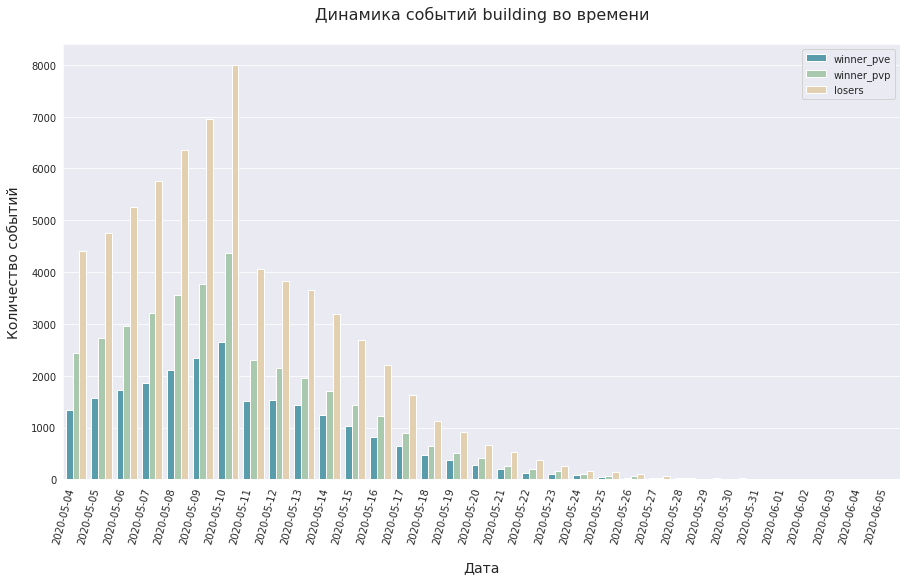

In [30]:
# применим функцию для построения столбиковой диаграммы
event_by_date_barplot('building', '#4ba5ba', '#a2ceaa', '#ecd2a8')

#### Динамика событий «первый уровень завершён» во времени

In [31]:
# применим функцию к событию «первый уровень завершён»
event_by_date('finished_stage_1')

Количество событий finished_stage_1 в первые 5 дней



,date,event_cnt
0,2020-05-04,1
1,2020-05-05,3
2,2020-05-06,4
3,2020-05-07,11
4,2020-05-08,28




Количество событий finished_stage_1 в последние 5 дней



,date,event_cnt
28,2020-06-01,7
29,2020-06-02,5
30,2020-06-03,3
31,2020-06-04,5
32,2020-06-05,3




Дата с максимальным количеством событий finished_stage_1: 2020-05-16 ( 649 события )
Дата с минимальным количеством событий finished_stage_1: 2020-05-04 ( 1 события )


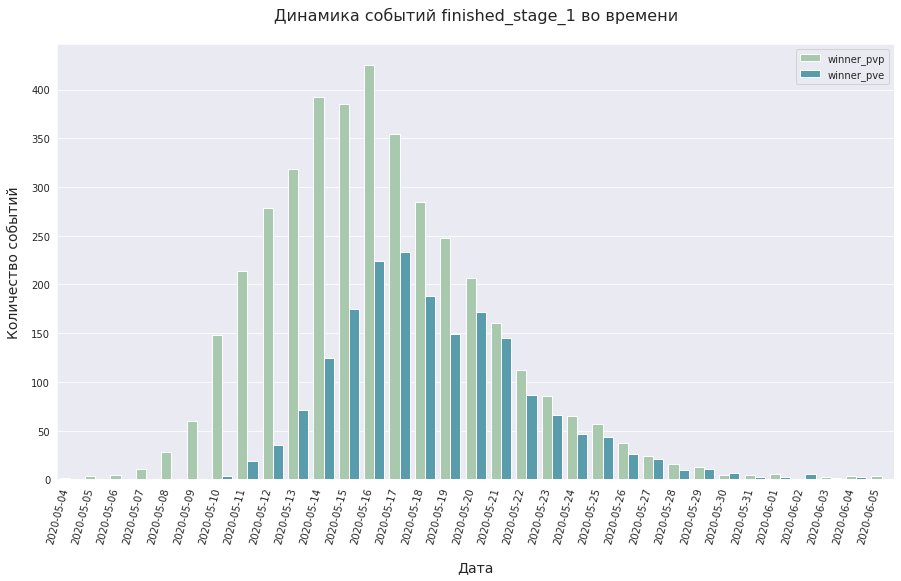

In [32]:
# применим функцию для построения столбиковой диаграммы
event_by_date_barplot('finished_stage_1', '#a2ceaa', '#4ba5ba', '#ecd2a8')

#### Динамика события «реализация проекта» во времени

In [33]:
# применим функцию к событию «реализация проекта»
event_by_date('project')

Количество событий project в первые 5 дней



,date,event_cnt
0,2020-05-08,1
1,2020-05-09,3
2,2020-05-10,34
3,2020-05-11,76
4,2020-05-12,96




Количество событий project в последние 5 дней



,date,event_cnt
23,2020-05-31,4
24,2020-06-01,1
25,2020-06-02,4
26,2020-06-03,1
27,2020-06-04,1




Дата с максимальным количеством событий project: 2020-05-15 ( 237 события )
Дата с минимальным количеством событий project: 2020-05-08 ( 1 события )


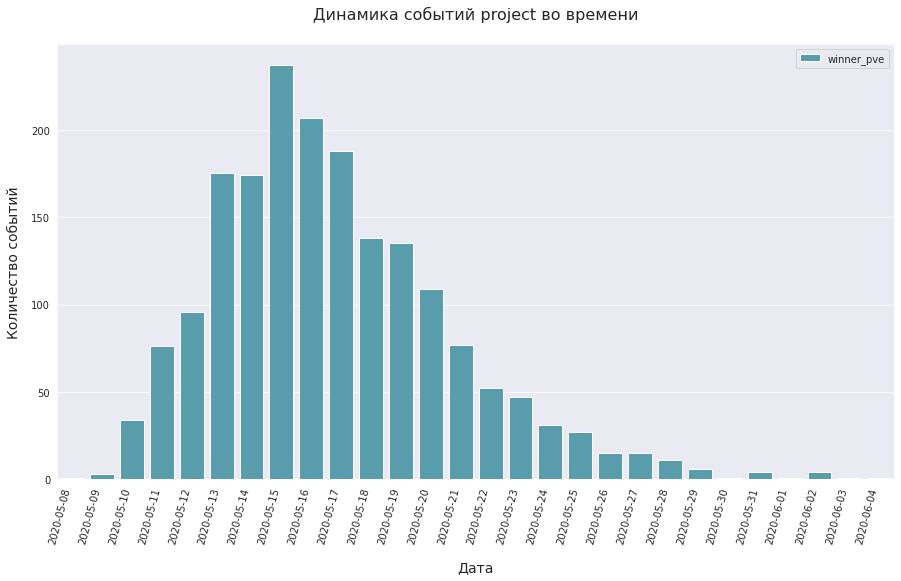

In [34]:
# применим функцию для построения столбиковой диаграммы
event_by_date_barplot('project', '#4ba5ba', '#a2ceaa', '#ecd2a8')

#### **Вывод**

- Максимальное количество объектов построили 10 мая — 15 022 здания. 11 мая наблюдается резкий спад активности постройки объектов практически в два раза. В последний день исследования 5 июня построили наименьшее количество объектов — всего 2 здания. Больше всего объектов строят игроки, не прошедшие первый уровень. На втором месте по активности постройки объектов игроки PvP. Меньше всего зданий строят игроки PvE.

- 16 мая больше всего игроков, прошедших первый уровень — 649 событий. До 20 мая очевидно лидировали по проходам первого уровня игроки PvP. Вероятно, они раньше уставали строить здания. С 20-х чисел игроки PvE начинают приближаться по количеству к игрокам PvP.

- 15 и 16 мая больше всего игроков реализовали проект.

### Распределение пользователей по событиям 

In [35]:
# посмотрим распределение уникальных пользователей по событиям
user_by_event = (
    game_actions.groupby('event', as_index=False)
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'unique_user_cnt'})
    .sort_values(by='unique_user_cnt', ascending=False)
    .reset_index(drop=True)
)
# проверим результат
user_by_event

,event,unique_user_cnt
0,building,13576
1,finished_stage_1,5817
2,project,1866


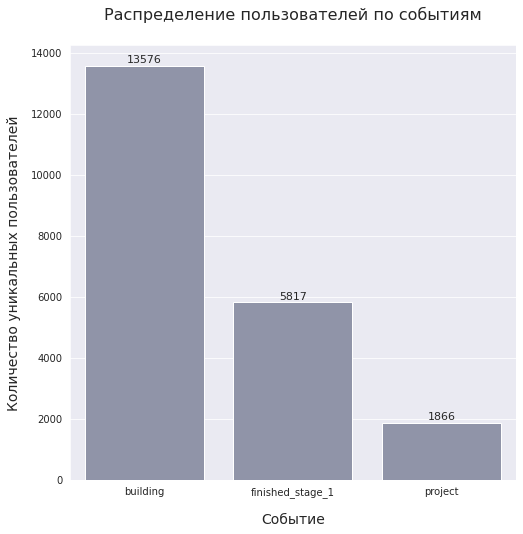

In [36]:
# построим столбиковую диаграмму
plt.figure(figsize=(8, 8))
plot = sns.barplot(
    x='event',
    y='unique_user_cnt',
    data=user_by_event,
    color='#8c92ac'
)
# добавим заголовок и подписи к осям
plt.title('Распределение пользователей по событиям', fontsize=16, pad=25)
plt.xlabel('Событие', fontsize=14, labelpad=15)
plt.ylabel('Количество уникальных пользователей', fontsize=14, labelpad=10)
  
# настроим аннотацию
total = user_by_event['unique_user_cnt'].sum()
for bar in plot.patches:
  text = '{:.0f}'.format(bar.get_height())
  percentage = '({:.1f}%)'.format(100 * bar.get_height() / total)
  x = bar.get_x() + bar.get_width() / 2
  y = bar.get_height() + 200
  plot.annotate(text, (x, y), ha='center', va='center', size=11)

In [37]:
# посмотрим распределение категорий пользователей по событиям
user_category_by_event = (
    game_actions.groupby(['event', 'user_category'], as_index=False)
    .agg({'user_id': ['nunique', 'count']})
)
# переименуем названия колонок датафрейма
user_category_by_event.columns = ['event', 'user_category', 'unique_user_cnt', 'event_cnt']

# отсортируем значения 
user_category_by_event = (
    user_category_by_event.sort_values(by=['event', 'unique_user_cnt'], ascending=True)
    .reset_index(drop=True)
)
# проверим результат
user_category_by_event

,event,user_category,unique_user_cnt,event_cnt
0,building,winner_pve,1866,23601
1,building,winner_pvp,3951,37185
2,building,losers,7759,67170
3,finished_stage_1,winner_pve,1866,1866
4,finished_stage_1,winner_pvp,3951,3951
5,project,winner_pve,1866,1866


In [38]:
# оставим в датафрейме только события по строительству объектов
buildings_per_user_category = user_category_by_event.query('event == "building"')

# найдём среднее количество построенных зданий по каждой категории пользователей
buildings_per_user_category['buildings_per_user'] = (
    round(buildings_per_user_category['event_cnt']\
          / buildings_per_user_category['unique_user_cnt']).astype('int')
)
# отсортируем значения в колонке 'buildings_per_user' по убыванию
buildings_per_user_category = (
    buildings_per_user_category.sort_values(by='buildings_per_user', ascending=False)
)
# проверим результат
display(buildings_per_user_category)
print()
print(
    'Игроки PvE в среднем строят',
    buildings_per_user_category['buildings_per_user'][0],
    'зданий'
)
print(
    'Игроки PvP в среднем строят',
    buildings_per_user_category['buildings_per_user'][1],
    'зданий'
)
print(
    'Игроки, не прошедшие первый уровень, в среднем строят',
    buildings_per_user_category['buildings_per_user'][2],
    'зданий'
)
print(
    'В среднем все игроки строят',
    buildings_per_user_category['buildings_per_user'].mean().astype('int'),
    'зданий'
)

,event,user_category,unique_user_cnt,event_cnt,buildings_per_user
0,building,winner_pve,1866,23601,13
1,building,winner_pvp,3951,37185,9
2,building,losers,7759,67170,9



Игроки PvE в среднем строят 13 зданий
Игроки PvP в среднем строят 9 зданий
Игроки, не прошедшие первый уровень, в среднем строят 9 зданий
В среднем все игроки строят 10 зданий


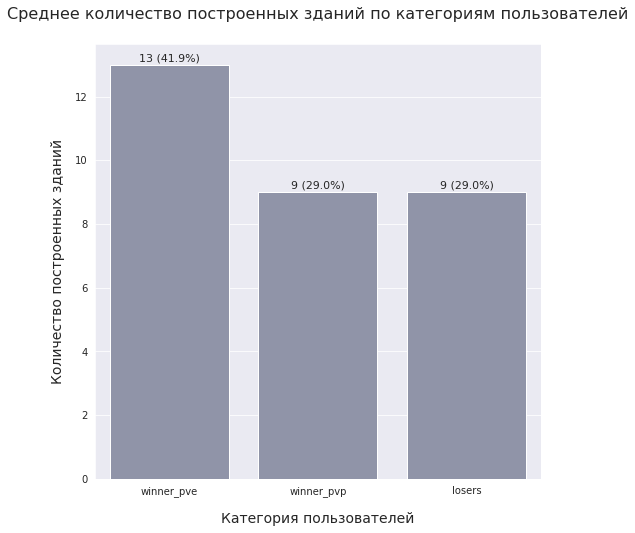

In [39]:
# построим столбиковую диаграмму
plt.figure(figsize=(8, 8))
plot = sns.barplot(
    x='user_category',
    y='buildings_per_user',
    data=buildings_per_user_category,
    color='#8c92ac'
)
# добавим заголовок и подписи к осям
plt.title(
    'Cреднее количество построенных зданий по категориям пользователей',
    fontsize=16, pad=25
)
plt.xlabel('Категория пользователей', fontsize=14, labelpad=15)
plt.ylabel('Количество построенных зданий', fontsize=14, labelpad=10)
  
# настроим аннотацию
total = buildings_per_user_category['buildings_per_user'].sum()
for bar in plot.patches:
  text = '{:.0f} '.format(bar.get_height())
  percentage = '({:.1f}%)'.format(100 * bar.get_height() / total)
  x = bar.get_x() + bar.get_width() / 2
  y = bar.get_height() + 0.2
  plot.annotate(text + percentage, (x, y), ha='center', va='center', size=11)

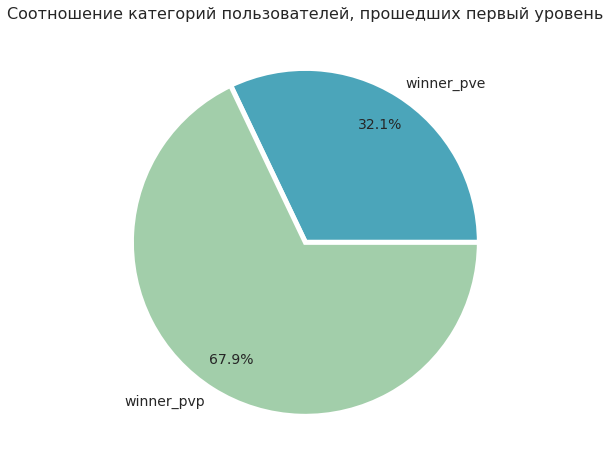

In [40]:
# построим круговую диаграмму по пользователям, прошедшим первым уровень
plt.figure(figsize=(8, 8))
colors = ['#4ba5ba', '#a2ceaa']
values = user_category_by_event.query(
    'event == "finished_stage_1"'
    )['unique_user_cnt']
names = list(user_category_by_event.query(
    'event == "finished_stage_1"'
    )['user_category'].unique())

plt.pie(
    values,
    labels=names,
    textprops={'fontsize': 14},
    labeldistance=1.08,
    autopct='%1.1f%%',
    pctdistance=0.8,
    wedgeprops = {'linewidth': 5, 'edgecolor': 'white'},
    colors=colors
)
# добавим заголовок
plt.title(
    'Соотношение категорий пользователей, прошедших первый уровень',
    fontsize=16
);

#### **Вывод**

- Выяснили, что все игроки, а именно 13 576 пользователей, построили хотя бы один объект. 
- В среднем все игроки строят 10 зданий.
  - игроки PvE в среднем строят больше — 13 зданий.
  - игроки PvP в среднем строят 9 зданий.
  - игроки, не прошедшие первый уровень, в среднем строят 9 зданий.
- Завершили первый уровень 5817 пользователей, из которых 67.9% — игроки PvP, а 32.1% — игроки PvE.

### Распределение построек по типам

In [41]:
# посмотрим распределение событий по типам зданий
event_by_building_type = (
    game_actions.query('building_type != "undefined"')
    .groupby('building_type', as_index=False)
    .agg({'event': 'count'})
    .rename(columns={'event': 'event_cnt'})
    .sort_values(by='event_cnt', ascending=False)
    .reset_index(drop=True)
)
# выделим доли в отдельную колонку
event_by_building_type['event_share'] = (
    round(event_by_building_type['event_cnt']\
          / event_by_building_type['event_cnt'].sum() * 100, 1)
)
# проверим результат
display(event_by_building_type)
print()
print('Сумма построенных объектов:', event_by_building_type['event_cnt'].sum())

,building_type,event_cnt,event_share
0,spaceport,59325,46.4
1,assembly_shop,54494,42.6
2,research_center,14137,11.0



Сумма построенных объектов: 127956


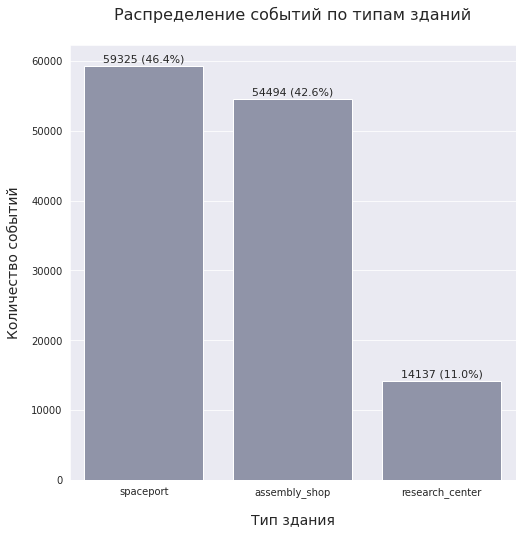

In [42]:
# построим столбиковую диаграмму
plt.figure(figsize=(8, 8))
plot = sns.barplot(
    x='building_type',
    y='event_cnt',
    data=event_by_building_type,
    color='#8c92ac'
)
# добавим заголовок и подписи к осям
plt.title(
    'Распределение событий по типам зданий',
    fontsize=16, pad=25
)
plt.xlabel('Тип здания', fontsize=14, labelpad=15)
plt.ylabel('Количество событий', fontsize=14, labelpad=10)
  
# настроим аннотацию
total = event_by_building_type['event_cnt'].sum()
for bar in plot.patches:
  text = '{:.0f} '.format(bar.get_height())
  percentage = '({:.1f}%)'.format(100 * bar.get_height() / total)
  x = bar.get_x() + bar.get_width() / 2
  y = bar.get_height() + 1000
  plot.annotate(text + percentage, (x, y), ha='center', va='center', size=11)

In [43]:
# посмотрим распределение событий по типам зданий в разрезе категорий пользователей
user_category_by_building_type = (
    game_actions.query('building_type != "undefined"')
    .groupby(['building_type', 'user_category'], as_index=False)
    .agg({'event': 'count'})
    .rename(columns={'event': 'event_cnt'})
    .sort_values(by=['event_cnt', 'building_type'], ascending=False)
    .reset_index(drop=True)
)
# выделим сумму событий по каждому типу зданий в отдельную колонку
user_category_by_building_type['event_category_sum'] = (
    user_category_by_building_type.groupby('building_type')['event_cnt'].transform('sum')
)
# выделим доли событий по каждому типу зданий в отдельную колонку
user_category_by_building_type['event_category_share'] = (
    round(user_category_by_building_type['event_cnt']\
          / user_category_by_building_type['event_category_sum'] * 100, 1)
)
# проверим результат
user_category_by_building_type

,building_type,user_category,event_cnt,event_category_sum,event_category_share
0,spaceport,losers,31405,59325,52.9
1,assembly_shop,losers,29080,54494,53.4
2,spaceport,winner_pvp,17132,59325,28.9
3,assembly_shop,winner_pvp,16298,54494,29.9
4,spaceport,winner_pve,10788,59325,18.2
5,assembly_shop,winner_pve,9116,54494,16.7
6,research_center,losers,6685,14137,47.3
7,research_center,winner_pvp,3755,14137,26.6
8,research_center,winner_pve,3697,14137,26.2


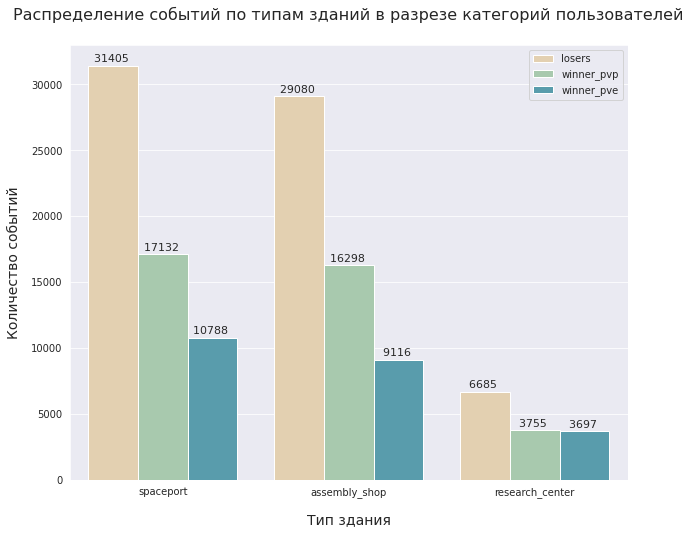

In [44]:
# построим столбиковую диаграмму
plt.figure(figsize=(10, 8))
palette = ['#ecd2a8', '#a2ceaa', '#4ba5ba']
plot = sns.barplot(
    x='building_type',
    y='event_cnt',
    hue='user_category',
    data=user_category_by_building_type,
    palette=palette
)
plt.legend(loc=1);

# добавим заголовок и подписи к осям
plt.title(
    'Распределение событий по типам зданий в разрезе категорий пользователей',
    fontsize=16, pad=25
)
plt.xlabel('Тип здания', fontsize=14, labelpad=15)
plt.ylabel('Количество событий', fontsize=14, labelpad=10)

# настроим аннотацию
for bar in plot.patches:
  text = '{:.0f} '.format(bar.get_height())
  x = bar.get_x() + bar.get_width() / 2
  y = bar.get_height() + 500
  plot.annotate(text, (x, y), ha='center', va='center', size=11)

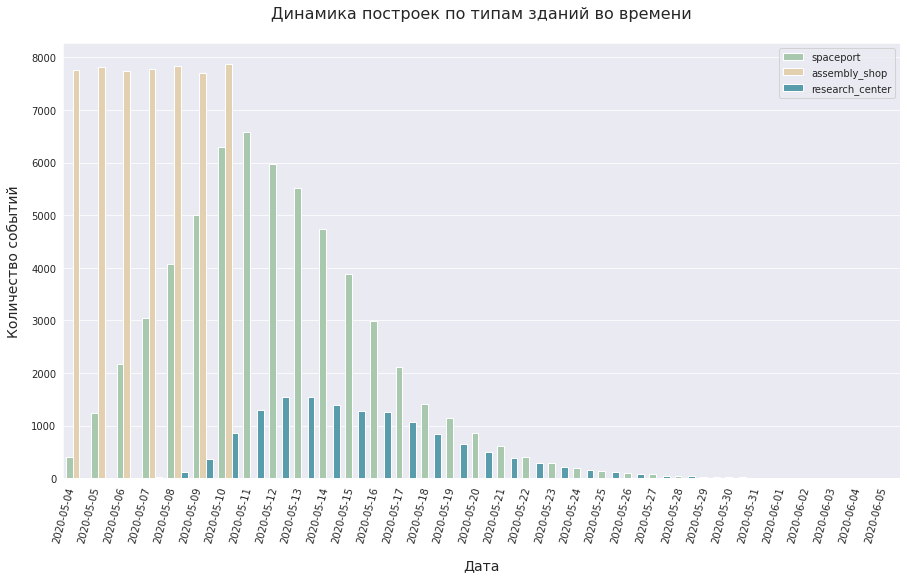

In [45]:
# построим столбиковую диаграмму с разделением по категориям
plt.figure(figsize=(15, 8))
data = (
    game_actions[game_actions['event'] == 'building']
    .groupby(['date', 'building_type'], as_index=False)['user_id'].count()
    .sort_values(by=['date', 'user_id'], ascending=True)
)
sns.barplot(
    x='date',
    y='user_id',
    hue='building_type',
    data=data,
    palette=['#a2ceaa', '#ecd2a8', '#4ba5ba']
)
# добавим легенду, заголовок и подписи к осям
plt.legend(loc=1)
plt.title(
    'Динамика построек по типам зданий во времени',
    fontsize=16, pad=25
)
plt.xlabel('Дата', fontsize=14, labelpad=15)
plt.ylabel('Количество событий', fontsize=14, labelpad=10)
plt.xticks(rotation=75, ha='right');

#### **Вывод**

- Всего построено 127 956 зданий, из которых:
  - 46.4% космопортов. Больше всего космопортов (52.9%) построили игроки, не прошедшие первый уровень. Игроки PvP построили 28.9% космопортов, а игроки PvE — 18.2%.
  - 42.6% сборочных цехов. Больше всего сборочных цехов (53.4%) построили игроки, не прошедшие первый уровень. Игроки PvP построили 29.9% сборочных цехов, а игроки PvE — 16.7%.
  - 11% исследовательских центров. Больше всего исследовательских центров (47.3%) построили игроки, не прошедшие первый уровень. Игроки PvP и игроки PvE построили сопоставимое количество исследовательских центров — 26.6% и 26.2% соответственно.
- До 10 мая включительно игроки максимально строили сборочные цеха — более 7000 событий в день. С 11 мая сборочные цеха не строят совсем и пик событий переходит на построение космопортов — более 6000 событий. Далее по ним идёт плавное снижение и уже с 16 мая не превышает 3000 космопортов в день. Пик построения исследовательских центров приходится на 12 и 13 марта, но не превышает 1540 событий.

### Среднее число сессий на пользователя

In [46]:
# рассчитаем среднее число сессий на пользователя за весь период исследования 
print(
    'Cреднее число сессий на пользователя за весь период исследования:',
    round(len(game_actions['event_datetime']) / game_actions['user_id'].nunique())
)

Cреднее число сессий на пользователя за весь период исследования: 10


In [47]:
# рассчитаем среднее число сессий на пользователя в день 
visits_per_user = (
    game_actions.groupby('date')
    .agg({'user_id': ['count', 'nunique']})
)
# переименуем названия колонок датафрейма
visits_per_user.columns = ['visits', 'users']

# уберём двухэтажные названия колонок
visits_per_user = visits_per_user.reset_index(col_level=1).rename_axis(columns=None)

# добавим колонку со средним числом сессий на пользователя в день
visits_per_user['visits_per_user'] = (
    round(visits_per_user['visits'] / visits_per_user['users'])
)
# переведём значения в колонке к целочисленному типу 
visits_per_user['visits_per_user'] = visits_per_user['visits_per_user'].astype('int')

# проверим результат
display(visits_per_user.head())
print()
print(
    'Cреднее число сессий в день:',
    round(visits_per_user['visits'].mean())
)
print(
    'Дата с максимальным числом сессий в день:',
    visits_per_user.loc[visits_per_user['visits'].idxmax()][0].strftime('%Y-%m-%d'),
    '(', visits_per_user['visits'].max(), 'сессий )'
)
print()
print(
    'Cреднее число уникальных пользователей в день:',
    round(visits_per_user['users'].mean())
)
print(
    'Дата с максимальным числом уникальных пользователей в день:',
    visits_per_user.loc[visits_per_user['users'].idxmax()][0].strftime('%Y-%m-%d'),
    '(', visits_per_user['users'].max(), 'пользователей )'
)
print()
print(
    'Среднее число сессий на пользователя в день:',
    round(visits_per_user['visits_per_user'].mean())
)

,date,visits,users,visits_per_user
0,2020-05-04,8171,5860,1
1,2020-05-05,9055,6382,1
2,2020-05-06,9925,6854,1
3,2020-05-07,10858,7384,1
4,2020-05-08,12059,7891,2



Cреднее число сессий в день: 4110
Дата с максимальным числом сессий в день: 2020-05-10 ( 15207 сессий )

Cреднее число уникальных пользователей в день: 2885
Дата с максимальным числом уникальных пользователей в день: 2020-05-10 ( 9219 пользователей )

Среднее число сессий на пользователя в день: 1


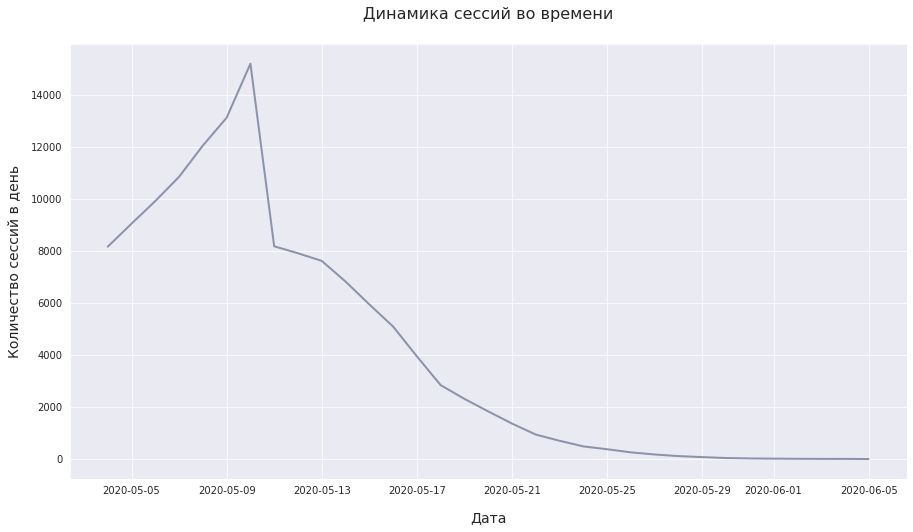

In [48]:
# построим линейный график
plt.figure(figsize=(15, 8))
plot = sns.lineplot(
    x='date',
    y='visits',
    data=visits_per_user,
    color='#8c92ac',
    linewidth=2
)
# добавим заголовок и подписи к осям
plt.title('Динамика сессий во времени', fontsize=16, pad=25)
plt.xlabel('Дата', fontsize=14, labelpad=15)
plt.ylabel('Количество сессий в день', fontsize=14, labelpad=10);

#### **Вывод**

- За весь период исследования пользователь в среднем совершает 10 сессий.
- В среднем пользователь заходит в игру  1 раз в день.
- Cреднее число сессий в день — 4110 сессий. Максимальное число сессий пришлось на 10 мая — 15 207 сессий. Затем произошло резкое падение активности, и с 16 мая число сессий не превышало 4000.
- Cреднее число уникальных пользователей в день — 2885 пользователей. Максимальное число уникальных пользователей также наблюдалось 10 мая — 9219 пользователей.

### Среднее время прохождения первого уровня

In [49]:
# выделим первый и последний визит игроков, прошедших первый уровень
time_finished_stage_1 = (
    game_actions.query('user_category != "losers"')
    .groupby(['user_id', 'user_category'], as_index=False)
    .agg({'event_datetime': ['min', 'max']})
)
# переименуем названия колонок датафрейма
time_finished_stage_1.columns = ['user_id', 'user_category', 'first_visit', 'last_visit']

# добавим колонку с расчётом времени прохождения первого уровня каждым игроком
time_finished_stage_1['time_to_complete'] = (
    time_finished_stage_1['last_visit'] - time_finished_stage_1['first_visit']
)
# добавим колонку с расчётом количества дней прохождения первого уровня каждым игроком
time_finished_stage_1['day_to_complete'] = (
    time_finished_stage_1['time_to_complete'] / np.timedelta64(1, 'D')
)
# округлим значения в колонке 'day_to_complete' до целого значения
time_finished_stage_1['day_to_complete'] = (
    time_finished_stage_1['day_to_complete'].round().astype('int')
)
# проверим результат
display(time_finished_stage_1.head())
print()
print('\033[1m' + 'Статистика времени прохождения уровня по всем игрокам')
display(time_finished_stage_1['time_to_complete'].describe())
print()
print('\033[1m' + 'Статистика времени прохождения уровня игроками PvP')
display(
    time_finished_stage_1.query(
        'user_category == "winner_pvp"'
        )['time_to_complete'].describe()
)
print()
print('\033[1m' + 'Статистика времени прохождения уровня игроками PvE')
display(
    time_finished_stage_1.query(
        'user_category == "winner_pve"'
        )['time_to_complete'].describe()
)

,user_id,user_category,first_visit,last_visit,time_to_complete,day_to_complete
0,001d39dc-366c-4021-9604-6a3b9ff01e25,winner_pvp,2020-05-05 21:02:05,2020-05-12 07:40:47,6 days 10:38:42,6
1,003ee7e8-6356-4286-a715-62f22a18d2a1,winner_pvp,2020-05-05 08:31:04,2020-05-17 21:47:49,12 days 13:16:45,13
2,004074f8-251a-4776-922c-8348dca1a2f6,winner_pvp,2020-05-04 01:07:35,2020-05-16 19:57:40,12 days 18:50:05,13
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,winner_pvp,2020-05-04 08:35:29,2020-05-15 16:02:01,11 days 07:26:32,11
4,0056c007-c082-43cc-bdef-afc49bca4cb9,winner_pvp,2020-05-10 11:49:47,2020-05-16 13:48:39,6 days 01:58:52,6



Статистика времени прохождения уровня по всем игрокам


count                          5817
mean     11 days 20:37:59.561801616
std       4 days 01:37:33.183162346
min                 0 days 09:39:01
25%                 9 days 05:13:21
50%                11 days 13:28:44
75%                14 days 05:15:16
max                30 days 21:58:53
Name: time_to_complete, dtype: object


Статистика времени прохождения уровня игроками PvP


count                          3951
mean     11 days 02:30:24.076183244
std       4 days 02:17:54.287406787
min                 0 days 09:39:01
25%          8 days 07:01:19.500000
50%                10 days 19:01:37
75%         13 days 10:33:17.500000
max                30 days 21:58:53
Name: time_to_complete, dtype: object


Статистика времени прохождения уровня игроками PvE


count                          1866
mean     13 days 11:00:49.135048231
std       3 days 12:11:01.977069676
min                 5 days 03:22:27
25%         10 days 22:49:58.750000
50%                13 days 00:45:41
75%         15 days 13:47:23.750000
max                29 days 03:13:43
Name: time_to_complete, dtype: object

#### **Вывод**

Среднее время прохождения первого уровня игроками 11-12 дней. Отметим, в среднем игроки PvP проходят уровень примерно на 2 дня быстрее игроков PvE. 

## Проведение маркетингового анализа данных

### Период проведения рекламной кампании

In [50]:
# посмотрим период проведения рекламной кампании
first_day = ad_costs['day'].min().strftime('%Y-%m-%d')
last_day = ad_costs['day'].max().strftime('%Y-%m-%d')
period_adv = round(
    (ad_costs['day'].max() - ad_costs['day'].min()) / np.timedelta64(1, 'D')
)
print('Первый день рекламной кампании:', first_day)
print('Последний день рекламной кампании:', last_day)
print('Количество дней рекламной кампании:', period_adv)

Первый день рекламной кампании: 2020-05-03
Последний день рекламной кампании: 2020-05-09
Количество дней рекламной кампании: 6


#### **Вывод**

Период проведения рекламной кампании составляет 6 дней — с 3 по 9 мая 2020 года.

### Распределение расходов по рекламным источникам

In [51]:
print('Общая сумма расходов на маркетинг:', round(ad_costs['cost'].sum()))
print(
    'Средняя сумма расходов в день:', round(ad_costs['cost'].sum() / period_adv) 
)

Общая сумма расходов на маркетинг: 7604
Средняя сумма расходов в день: 1267


In [52]:
# посмотрим распределение расходов по рекламным источникам
cost_by_source = (
    ad_costs.groupby('source', as_index=False)
    .agg({'cost': 'sum'})
    .rename(columns={'cost': 'cost_sum'})
    .sort_values(by='cost_sum', ascending=False)
    .reset_index(drop=True)
)
# округлим значения в колонке 'cost_sum' до одного знака после запятой
cost_by_source['cost_sum'] = round(cost_by_source['cost_sum'], 1)

# выделим доли в отдельную колонку
cost_by_source['cost_share'] = (
    round(cost_by_source['cost_sum'] / cost_by_source['cost_sum'].sum() * 100, 1))

# проверим результат
cost_by_source

,source,cost_sum,cost_share
0,yandex,2233.1,29.4
1,instagram,2161.4,28.4
2,facebook,2140.9,28.2
3,youtube,1068.1,14.0


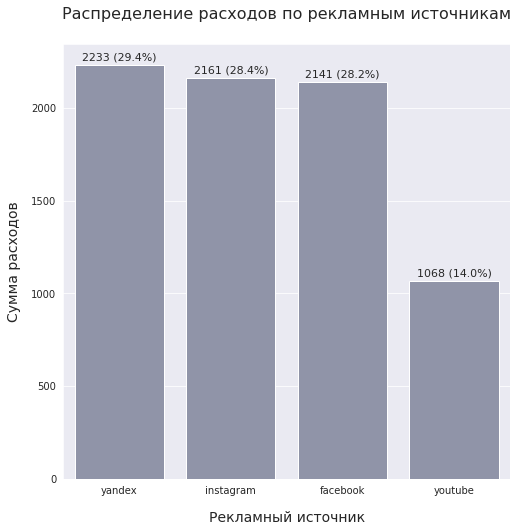

In [53]:
# построим столбиковую диаграмму
plt.figure(figsize=(8, 8))
plot = sns.barplot(
    x='source',
    y='cost_sum',
    data=cost_by_source,
    color='#8c92ac'
)
# добавим заголовок и подписи к осям
plt.title(
    'Распределение расходов по рекламным источникам',
    fontsize=16, pad=25
)
plt.xlabel('Рекламный источник', fontsize=14, labelpad=15)
plt.ylabel('Сумма расходов', fontsize=14, labelpad=10)
  
# настроим аннотацию
total = cost_by_source['cost_sum'].sum()
for bar in plot.patches:
  text = '{:.0f} '.format(bar.get_height())
  percentage = '({:.1f}%)'.format(100 * bar.get_height() / total)
  x = bar.get_x() + bar.get_width() / 2
  y = bar.get_height() + 40
  plot.annotate(text + percentage, (x, y), ha='center', va='center', size=11)

#### **Вывод**

- Общая сумма расходов на маркетинг составляет 7604 у.е. за 6 дней. То есть за один день рекламы  создатели игры тратят в среднем 1267 у.е.
- В целом расходы распределены равномерно между тремя источниками — Yandex (29.4%), Instagram (28.4%) и Facebook (28.2%). Расходы на рекламу в Youtube по сравнению с другими источниками в два раза меньше — 14%.

### Динамика расходов во времени по каждому источнику

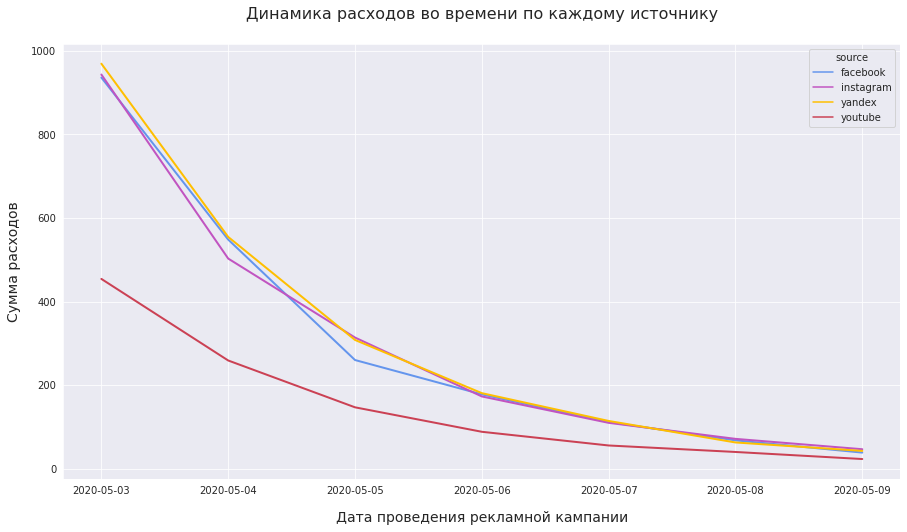

In [54]:
# построим линейный график
plt.figure(figsize=(15, 8))
plot = sns.lineplot(
    x='day',
    y='cost',
    hue='source',
    data=ad_costs,
    palette=['#6495ed', '#c154c1', '#ffbf00', '#cb4154'],
    linewidth=2
)
# добавим заголовок и подписи к осям
plt.title('Динамика расходов во времени по каждому источнику', fontsize=16, pad=25)
plt.xlabel('Дата проведения рекламной кампании', fontsize=14, labelpad=15)
plt.ylabel('Сумма расходов', fontsize=14, labelpad=10);

#### **Вывод**

По всем источникам наблюдается схожая тенденция. В первые три дня рекламной кампании расходы резко снижались — с каждым днём падали практически в 2 раза по сравнению с предыдущим днём. Затем мы видим стабильно плавное снижение расходов.

### Распределение пользователей по рекламным источникам

In [55]:
# посмотрим распределение пользователей по рекламным источникам
user_by_source = (
    game_actions.groupby('source', as_index=False)
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'unique_user_cnt'})
    .sort_values(by='unique_user_cnt', ascending=False)
    .reset_index(drop=True)
)
# выделим доли в отдельную колонку
user_by_source['unique_user_share'] = (
    round(user_by_source['unique_user_cnt']\
          / user_by_source['unique_user_cnt'].sum() * 100, 1)
)
# проверим результат
display(user_by_source)
print()
# убедимся, что сумма совпадает с числом уникальных пользователей исходного датафрейма
print('Всего уникальных пользователей:', user_by_source['unique_user_cnt'].sum())

,source,unique_user_cnt,unique_user_share
0,yandex,4817,35.5
1,instagram,3347,24.7
2,facebook,2726,20.1
3,youtube,2686,19.8



Всего уникальных пользователей: 13576


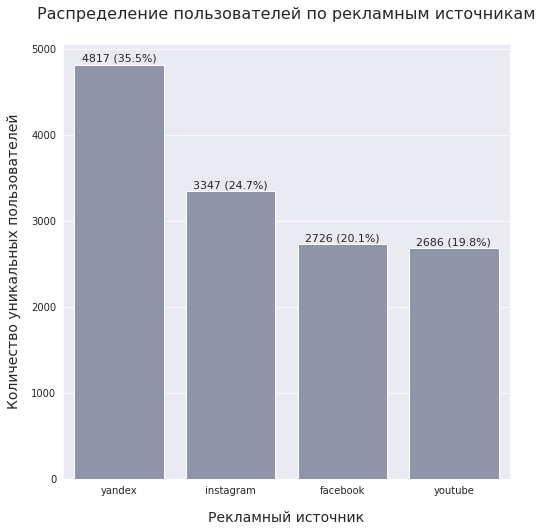

In [56]:
# построим столбиковую диаграмму
plt.figure(figsize=(8, 8))
plot = sns.barplot(
    x='source',
    y='unique_user_cnt',
    data=user_by_source,
    color='#8c92ac'
)
# добавим заголовок и подписи к осям
plt.title(
    'Распределение пользователей по рекламным источникам',
    fontsize=16, pad=25
)
plt.xlabel('Рекламный источник', fontsize=14, labelpad=15)
plt.ylabel('Количество уникальных пользователей', fontsize=14, labelpad=10)

# настроим аннотацию
total = user_by_source['unique_user_cnt'].sum()
for bar in plot.patches:
  text = '{:.0f} '.format(bar.get_height())
  percentage = '({:.1f}%)'.format(100 * bar.get_height() / total)
  x = bar.get_x() + bar.get_width() / 2
  y = bar.get_height() + 70
  plot.annotate(text + percentage, (x, y), ha='center', va='center', size=11)

In [57]:
# посмотрим распределение категорий пользователей по рекламным источникам
user_category_by_source = (
    game_actions.groupby(['source', 'user_category'], as_index=False)
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'unique_user_cnt'})
    .sort_values(by=['unique_user_cnt', 'source'], ascending=False)
    .reset_index(drop=True)
)
# выделим сумму событий по каждому источнику в отдельную колонку
user_category_by_source['unique_user_sum'] = (
    user_category_by_source.groupby('source')['unique_user_cnt'].transform('sum')
)
# выделим доли событий по каждому типу источнику в отдельную колонку
user_category_by_source['unique_user_share'] = (
    round(user_category_by_source['unique_user_cnt']\
          / user_category_by_source['unique_user_sum'] * 100, 1)
)
# проверим результат
display(user_category_by_source)
print()
# убедимся, что сумма совпадает с числом уникальных пользователей исходного датафрейма
print(
    'Всего уникальных пользователей:',
    user_category_by_source['unique_user_cnt'].sum()
)

,source,user_category,unique_user_cnt,unique_user_sum,unique_user_share
0,yandex,losers,2775,4817,57.6
1,instagram,losers,1881,3347,56.2
2,facebook,losers,1576,2726,57.8
3,youtube,losers,1527,2686,56.9
4,yandex,winner_pvp,1422,4817,29.5
5,instagram,winner_pvp,990,3347,29.6
6,youtube,winner_pvp,780,2686,29.0
7,facebook,winner_pvp,759,2726,27.8
8,yandex,winner_pve,620,4817,12.9
9,instagram,winner_pve,476,3347,14.2



Всего уникальных пользователей: 13576


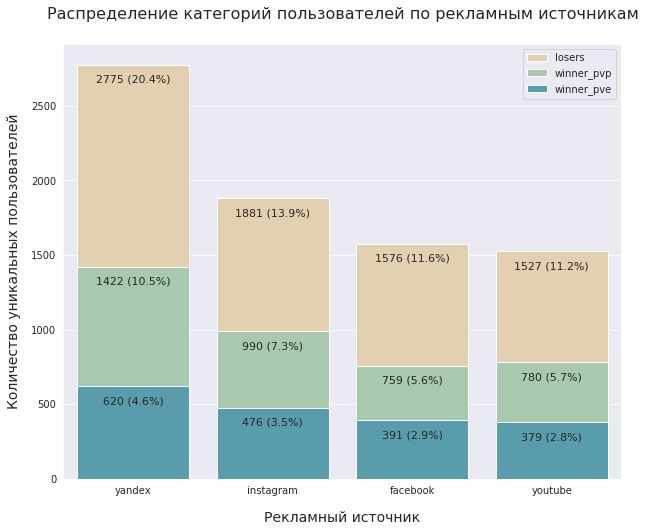

In [58]:
# построим столбиковую диаграмму
plt.figure(figsize=(10, 8))
palette = ['#ecd2a8', '#a2ceaa', '#4ba5ba']
plot = sns.barplot(
    x='source',
    y='unique_user_cnt',
    hue='user_category',
    data=user_category_by_source,
    dodge= False,
    palette=palette
)
plt.legend(loc=1);

# добавим заголовок и подписи к осям
plt.title(
    'Распределение категорий пользователей по рекламным источникам',
    fontsize=16, pad=25
)
plt.xlabel('Рекламный источник', fontsize=14, labelpad=15)
plt.ylabel('Количество уникальных пользователей', fontsize=14, labelpad=10)

# настроим аннотацию
total = user_category_by_source['unique_user_cnt'].sum()
for bar in plot.patches:
  text = '{:.0f} '.format(bar.get_height())
  percentage = '({:.1f}%)'.format(100 * bar.get_height() / total)
  x = bar.get_x() + bar.get_width() / 2
  y = bar.get_height() - 100
  plot.annotate(text + percentage, (x, y), ha='center', va='center', size=11)

In [59]:
# посмотрим количество уникальных пользователей в день
users_by_day = (
    game_actions.groupby(['date', 'source'], as_index=False)
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'unique_user_cnt'})
)
# проверим результат
users_by_day.head()

,date,source,unique_user_cnt
0,2020-05-04,facebook,1184
1,2020-05-04,instagram,1452
2,2020-05-04,yandex,2078
3,2020-05-04,youtube,1146
4,2020-05-05,facebook,1328


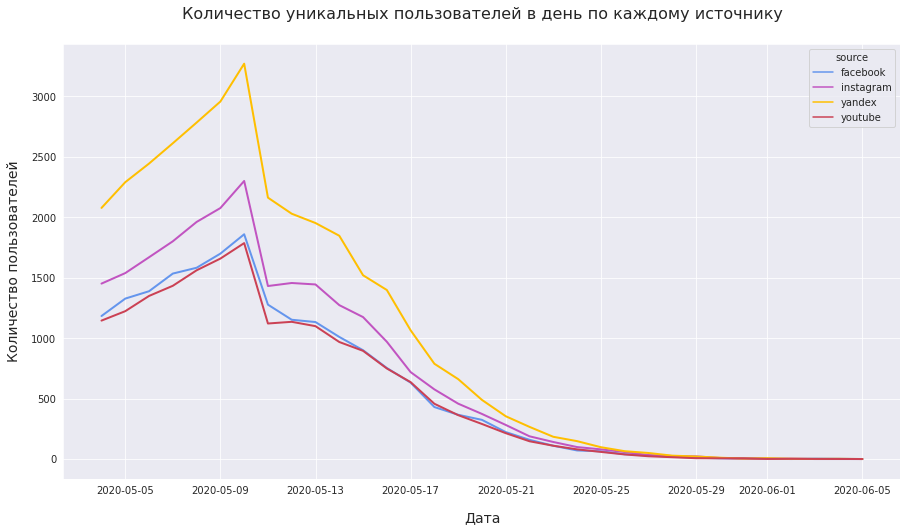

In [60]:
# построим линейный график
plt.figure(figsize=(15, 8))
plot = sns.lineplot(
    x='date',
    y='unique_user_cnt',
    hue='source',
    data=users_by_day,
    palette=['#6495ed', '#c154c1', '#ffbf00', '#cb4154'],
    linewidth=2
)
# добавим заголовок и подписи к осям
plt.title(
    'Количество уникальных пользователей в день по каждому источнику',
    fontsize=16, pad=25
)
plt.xlabel('Дата', fontsize=14, labelpad=15)
plt.ylabel('Количество пользователей', fontsize=14, labelpad=10);

#### **Вывод**

Распределение уникальных пользователей по рекламным источникам следующее:

- **35.5%** — Yandex. Из них от общего числа пользователей 20.4% игроков, не прошедшие первый уровень, 10.5% игроков PvP и 4.6% игроков PvE.
- **24.7%** — Instagram. Из них от общего числа пользователей 13.9% игроков, не прошедшие первый уровень, 7.3% игроков PvP и 3.5% игроков PvE.
- **20.1%** — Facebook. Из них от общего числа пользователей 11.6% игроков, не прошедшие первый уровень, 5.6% игроков PvP и 2.9% игроков PvE.
- **19.8%** — Youtube. Из них 11.2% игроков, не прошедшие первый уровень, 5.7% игроков PvP и 2.8% игроков PvE.  

С начала исследования заметен стремительный рост активности пользователей. Пик приходится на 10 мая. Вероятно, ещё действует эффект от рекламной кампании. С 11 мая наблюдается резкое падение активности. Скорее всего, ещё одна причина в том, что после 10 мая новые пользователи вообще не появлялись, так как набор в тестовую когорту был закрыт. В разрезе рекламных источников на первом месте по количеству уникальных пользователей в день находится Yandex, на втором месте Instagram. Для Facebook и Youtube активность уникальных пользователей сопоставимая.

### Cтоимость привлечения одного пользователя из каждого источника (CAC)


In [61]:
# добавим к датафрейму с числом уникальных пользователей по источникам
# данные о расходах по источникам
cac_by_source = user_by_source.merge(cost_by_source, on='source', how='left')

# рассчитаем стоимость привлечения одного пользователя из каждого источника
cac_by_source['cac'] = (
    round(cac_by_source['cost_sum'] / cac_by_source['unique_user_cnt'], 2)
)
# отсортируем значения по убыванию cac
cac_by_source = cac_by_source.sort_values(by='cac', ascending=False)

# проверим результат
display(cac_by_source)
print()
print(
    'Средняя стоимость привлечения одного пользователя:',
    round(cac_by_source['cac'].mean(), 2)
)

,source,unique_user_cnt,unique_user_share,cost_sum,cost_share,cac
2,facebook,2726,20.1,2140.9,28.2,0.79
1,instagram,3347,24.7,2161.4,28.4,0.65
0,yandex,4817,35.5,2233.1,29.4,0.46
3,youtube,2686,19.8,1068.1,14.0,0.40



Средняя стоимость привлечения одного пользователя: 0.57


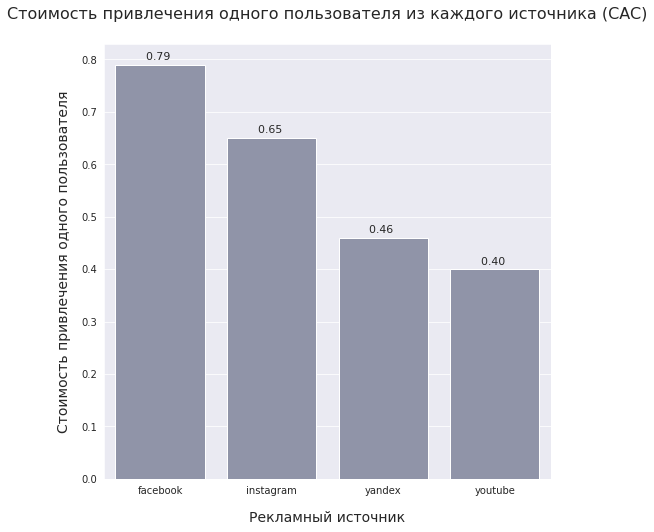

In [62]:
# построим столбиковую диаграмму
plt.figure(figsize=(8, 8))
plot = sns.barplot(
    x='source',
    y='cac',
    data=cac_by_source,
    color='#8c92ac'
)
# добавим заголовок и подписи к осям
plt.title(
    'Cтоимость привлечения одного пользователя из каждого источника (CAC)',
    fontsize=16, pad=25
)
plt.xlabel('Рекламный источник', fontsize=14, labelpad=15)
plt.ylabel(
    'Cтоимость привлечения одного пользователя',
    fontsize=14, labelpad=10
)
# настроим аннотацию
for bar in plot.patches:
  text = '{:.2f} '.format(bar.get_height())
  x = bar.get_x() + bar.get_width() / 2
  y = bar.get_height() + 0.015
  plot.annotate(text, (x, y), ha='center', va='center', size=11)

#### **Вывод**

Средняя стоимость привлечения одного пользователя составляет 0.58 у.е. Самыми бюджетными способами привлечения пользователей являются Youtube и Yandex — 0.40 у.е и 0.46 у.е. за одного пользователя соответственно. В Instagram и Facebook стоимость привлечения одного пользователя выше средней — 0.65 у.е. и 0.79 у.е. соответственно.

### Формирование модели монетизации

У нас есть следующие данные:

- Общая сумма расходов на маркетинг составляет 7604 у.е. за 6 дней.
- Доход с одного просмотра рекламы — 0.07 у.е.
- Планируется показывать рекламу на экране выбором постройки.

Выберем оптимальное время для запуска рекламы и количество её показов.

In [63]:
# доход с одного просмотра рекламы
revenue_one_ad = 0.07

# общая сумма расходов на маркетинг
cost_total = 7604

# количество показов рекламы, необходимое для окупаемости
number_ads = round(cost_total / revenue_one_ad )

# проверим результат
print('Количество показов рекламы, необходимое для окупаемости:', number_ads)

Количество показов рекламы, необходимое для окупаемости: 108629


Рассмотрим сценарий, при котором на протяжении всего времени игрок будет видеть одну рекламу при стройке одного здания. Кроме самого первого здания, когда пользователю не будет показываться реклама, чтобы он не ушёл раньше, чем игра его затянет.

In [64]:
# выделим количество построенных зданий для каждого игрока за весь период
monetization_model = (
    game_actions.query('event == "building"')
    .groupby('user_id', as_index=False)
    .agg({'event': 'count'})
    .rename(columns={'event': 'buildings_cnt'})
)
# проверим результат
monetization_model.head()

,user_id,buildings_cnt
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13
1,00151b4f-ba38-44a8-a650-d7cf130a0105,9
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,4
3,001d39dc-366c-4021-9604-6a3b9ff01e25,8
4,002f508f-67b6-479f-814b-b05f00d4e995,12


In [65]:
# посмотрим описательную статистику колонки 'buildings_cnt'
round(monetization_model['buildings_cnt'].describe()).astype('int')

count    13576
mean         9
std          4
min          1
25%          6
50%         10
75%         12
max         20
Name: buildings_cnt, dtype: int64

In [66]:
# рассчитаем количество рекламы, исключив самую первую постройку
monetization_model['ad_cnt_exclude_1'] = (
    monetization_model['buildings_cnt'].apply(lambda x:
                                             0 if x == 1
                                             else x - 1)
)
# проверим результат
display(monetization_model.head())
print()
print(
    'Количество показов рекламы:',
    monetization_model['ad_cnt_exclude_1'].sum()
)
print(
    'Доход от рекламы будет составлять:',
    round(monetization_model['ad_cnt_exclude_1'].sum() * revenue_one_ad)
)
if round(monetization_model['ad_cnt_exclude_1'].sum() * revenue_one_ad) >= cost_total:
  print('\033[1m' + 'Реклама окупится')
else:
  print('\033[1m' + 'Реклама не окупится')

,user_id,buildings_cnt,ad_cnt_exclude_1
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13,12
1,00151b4f-ba38-44a8-a650-d7cf130a0105,9,8
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,4,3
3,001d39dc-366c-4021-9604-6a3b9ff01e25,8,7
4,002f508f-67b6-479f-814b-b05f00d4e995,12,11



Количество показов рекламы: 114380
Доход от рекламы будет составлять: 8007
Реклама окупится


Проверим, окупится ли реклама, если пропустить рекламу не на одной постройке, а на первых двух зданиях.

In [67]:
# рассчитаем количество рекламы, исключив две первые постройки
monetization_model['ad_cnt_exclude_2'] = (
    monetization_model['buildings_cnt'].apply(lambda x:
                                             0 if x == 1
                                             else x - 2)
)
# проверим результат
display(monetization_model.head())
print()
print(
    'Количество показов рекламы:',
    monetization_model['ad_cnt_exclude_2'].sum()
)
print(
    'Доход от рекламы будет составлять:',
    round(monetization_model['ad_cnt_exclude_2'].sum() * revenue_one_ad)
)
if round(monetization_model['ad_cnt_exclude_2'].sum() * revenue_one_ad) >= cost_total:
  print('\033[1m' + 'Реклама окупится')
else:
  print('\033[1m' + 'Реклама не окупится')

,user_id,buildings_cnt,ad_cnt_exclude_1,ad_cnt_exclude_2
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13,12,11
1,00151b4f-ba38-44a8-a650-d7cf130a0105,9,8,7
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,4,3,2
3,001d39dc-366c-4021-9604-6a3b9ff01e25,8,7,6
4,002f508f-67b6-479f-814b-b05f00d4e995,12,11,10



Количество показов рекламы: 100861
Доход от рекламы будет составлять: 7060
Реклама не окупится


Как видим, при таком сценарии реклама не окупится.

#### **Вывод**

Таким образом, реклама окупится, если на протяжении всего времени игрок будет видеть одну рекламу при стройке одного здания. Кроме самого первого здания, когда пользователю не будет показываться реклама, чтобы он не ушёл раньше, чем игра его затянет.

## Проверка статистических гипотез

### Гипотеза различия среднего времени прохождения уровня игроками PvP и игроками PvE

Сформулируем гипотезы:

- **Нулевая гипотеза:** среднее время прохождения уровня игроками PvP и игроками PvE равно друг другу.
- **Альтернативная гипотеза:** среднее время прохождения уровня игроками PvP и игроками PvE отличается.

Ранее мы рассчитывали время прохождения первого уровня каждым игроком. Посмотрим на данные и разделим игроков на две выборки — игроков PvP и игроков PvE.

In [68]:
# датафрейм с временем прохождения первого уровня каждым игроком
display(time_finished_stage_1.head())
print()

# выделим игроков PvP и проверим результат
winner_pvp_group_a = (
    time_finished_stage_1.query('user_category == "winner_pvp"')['day_to_complete']
)
print('\033[1m' + 'Выборка с игроками PvP' + '\n' + 'Размер выборки:', len(winner_pvp_group_a))
display(winner_pvp_group_a.head())
print()

# выделим игроков PvE и проверим результат
winner_pve_group_b = (
    time_finished_stage_1.query('user_category == "winner_pve"')['day_to_complete']
)
print('\033[1m' + 'Выборка с игроками PvE' + '\n' + 'Размер выборки:', len(winner_pve_group_b))
display(winner_pve_group_b.head())

,user_id,user_category,first_visit,last_visit,time_to_complete,day_to_complete
0,001d39dc-366c-4021-9604-6a3b9ff01e25,winner_pvp,2020-05-05 21:02:05,2020-05-12 07:40:47,6 days 10:38:42,6
1,003ee7e8-6356-4286-a715-62f22a18d2a1,winner_pvp,2020-05-05 08:31:04,2020-05-17 21:47:49,12 days 13:16:45,13
2,004074f8-251a-4776-922c-8348dca1a2f6,winner_pvp,2020-05-04 01:07:35,2020-05-16 19:57:40,12 days 18:50:05,13
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,winner_pvp,2020-05-04 08:35:29,2020-05-15 16:02:01,11 days 07:26:32,11
4,0056c007-c082-43cc-bdef-afc49bca4cb9,winner_pvp,2020-05-10 11:49:47,2020-05-16 13:48:39,6 days 01:58:52,6



Выборка с игроками PvP
Размер выборки: 3951


0     6
1    13
2    13
3    11
4     6
Name: day_to_complete, dtype: int64


Выборка с игроками PvE
Размер выборки: 1866


7     12
12    16
13    20
15    14
16    15
Name: day_to_complete, dtype: int64

Применим специальный метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: `scipy.stats.ttest_ind()`. Размер выборки с игроками PvP — 3951, а размер выборки с игроками PvE — 1866. Помним, «Правило большого пальца» простое: если выборки разного размера и/или можно предположить, что дисперсии у генеральных совокупностей разные, нужно указать `equal_var = False`.

In [69]:
# критический уровень статистической значимости
# если p-value окажется меньше него — отвергнем гипотезу
alpha = .05

results = st.ttest_ind(
    winner_pvp_group_a, 
    winner_pve_group_b,
    equal_var = False
    )
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.0867598832876934e-106
Отвергаем нулевую гипотезу


#### **Вывод**

Уровень значимости ниже 0.05, потому нулевую гипотезу отвергаем. Анализ данных сообщает, что в среднем времени прохождения первого уровня между группами есть статистически значимые различия.

### Гипотеза различия среднего количества построенных зданий у игроков PvP и игроков PvE

Сформулируем гипотезы:

- **Нулевая гипотеза:** среднее количество построенных зданий у игроков PvP и игроков PvE равно друг другу.
- **Альтернативная гипотеза:** среднее количество построенных зданий у игроков PvP и игроков PvE отличается.

Рассчитаем количество построенных зданий игроками, прошедшими первый уровень. Затем разделим игроков на две выборки — игроков PvP и игроков PvE.

In [70]:
# рассчитаем количество построенных зданий игроками, прошедшими первый уровень
buildings_by_winners = (
    game_actions.query('event == "building" & user_category != "losers"')
    .groupby(['user_id', 'user_category'], as_index=False)
    .agg({'event': 'count'})
    .rename(columns={'event': 'building_cnt'})
)
# проверим результат
display(buildings_by_winners.head())
print()

# выделим игроков PvP и проверим результат
winner_pvp_group_c = (
    buildings_by_winners.query('user_category == "winner_pvp"')['building_cnt']
)
print('\033[1m' + 'Выборка с игроками PvP' + '\n' + 'Размер выборки:', len(winner_pvp_group_c))
display(winner_pvp_group_c.head())
print()

# выделим игроков PvE и проверим результат
winner_pve_group_d = (
    buildings_by_winners.query('user_category == "winner_pve"')['building_cnt']
)
print('\033[1m' + 'Выборка с игроками PvE' + '\n' + 'Размер выборки:', len(winner_pve_group_d))
display(winner_pve_group_d.head())

,user_id,user_category,building_cnt
0,001d39dc-366c-4021-9604-6a3b9ff01e25,winner_pvp,8
1,003ee7e8-6356-4286-a715-62f22a18d2a1,winner_pvp,8
2,004074f8-251a-4776-922c-8348dca1a2f6,winner_pvp,12
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,winner_pvp,8
4,0056c007-c082-43cc-bdef-afc49bca4cb9,winner_pvp,3



Выборка с игроками PvP
Размер выборки: 3951


0     8
1     8
2    12
3     8
4     3
Name: building_cnt, dtype: int64


Выборка с игроками PvE
Размер выборки: 1866


7     11
12    12
13    11
15    13
16    13
Name: building_cnt, dtype: int64

Применим специальный метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: `scipy.stats.ttest_ind()`. Размер выборки с игроками PvP — 3951, а размер выборки с игроками PvE — 1866. Помним, «Правило большого пальца» простое: если выборки разного размера и/или можно предположить, что дисперсии у генеральных совокупностей разные, нужно указать `equal_var = False`.

In [71]:
# критический уровень статистической значимости
# если p-value окажется меньше него — отвергнем гипотезу
alpha = .05

results = st.ttest_ind(
    winner_pvp_group_c, 
    winner_pve_group_d,
    equal_var = False
    )
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.0
Отвергаем нулевую гипотезу


#### **Вывод**

Уровень значимости ниже 0.05, потому нулевую гипотезу отвергаем. Анализ данных сообщает, что в среднем количестве построенных зданий между группами есть статистически значимые различия.

## Общий вывод

**Период проведения исследования** составляет 32 дня — с 4 мая по 5 июня 2020 года.

- За всё время игрок в среднем совершает 10 сессий.
- В среднем пользователь заходит в игру  1 раз в день.
- Cреднее число сессий в день — 4110. Максимальная активность была 10 мая — 15 207 сессий. Затем произошло резкое падение активности, и с 16 мая число сессий не превышало 4000.
- Cреднее число уникальных пользователей в день — 2885.

---

**Три категории пользователей:**

1. Игроки PvE, прошедшие первый уровень через реализацию проекта.
2. Игроки PvP, прошедшие первый уровень через победу над первым врагом.
3. Игроки, не прошедших первый уровень.

---

**Три события:**

1. Объект построен. Все игроки, а именно 13 576 пользователей, построили хотя бы одно здание. В среднем все игроки строят 10 зданий. Игроки PvE в среднем строят больше — 13 зданий, игроки PvP — 9 зданий, игроки, не прошедшие первый уровень — 9 зданий.
2. Первый уровень завершён. Первый уровень завершили 5817 пользователей: 67.9% — игроки PvP, 32.1% — игроки PvE. Среднее время прохождения первого уровня игроками 11-12 дней. В среднем игроки PvP проходят уровень примерно на 2 дня быстрее игроков PvE. 16 мая больше всего игроков, прошедших первый уровень — 649 событий. 
3. Реализация проекта — разработка орбитальной сборки спутников. Она позволяет игрокам PvE завершить первый уровень.

---

**Всего построено 127 956 зданий:**

1. 46.4% космопортов.
2. 42.6% сборочных цехов.
3. 11% исследовательских центров.

Максимальное количество объектов построили 10 мая — 15 022 здания. 11 мая наблюдается резкий спад активности практически в два раза. Больше всего объектов строят игроки, не прошедшие первый уровень. На втором месте по активности постройки объектов игроки PvP. Меньше всего зданий строят игроки PvE.  

---

**Четыре источника трафика:**

1. Yandex.
- расход — 29.4% от общего числа,
- уникальных пользователей — 35.5% от общего числа,
- из них завершили уровень 15.1% игроков от числа всех пользователей,
- CAC = 0.46 у.е.

2. Instagram.
- расход — 28.4% от общего числа,
- уникальных пользователей — 24.7% от общего числа,
- из них завершили уровень 10.8% игроков от числа всех пользователей,
- CAC = 0.65 у.е.

3. Facebook.
- расход — 28.2% от общего числа,
- уникальных пользователей — 20.1% от общего числа,
- из них завершили уровень 8.5% игроков от числа всех пользователей,
- CAC = 0.79 у.е.

4. Youtube.
- расход — 14% от общего числа,
- уникальных пользователей — 19.8% от общего числа,
- из них завершили уровень 8.5% игроков от числа всех пользователей,
- CAC = 0.40 у.е.

Период проведения рекламной кампании составляет 6 дней — с 3 по 9 мая 2020 года. Общая сумма расходов на маркетинг составляет 7604 у.е. То есть за один день рекламы создатели игры тратят в среднем 1267 у.е. Средняя стоимость привлечения одного пользователя составляет 0.58 у.е. 

**Рекомендуется** рассмотреть перераспределение рекламного бюджета в пользу Yandex и Youtube. У этих источников наименьшая стоимость привлечения одного пользователя. Из Yandex пришло наибольшее число игроков, хотя на рекламу в Instagram и Facebook расходы были сопоставимые. Также больше всего игроков, завершивших первый уровень, пришли из Yandex. Перспективный канал — Youtube, однако в него вложили в 2 раза меньше средств, отсюда и меньший процент уникальных пользователей. Возможно, если вложить в него больше средств, показатели могут приблизиться к Yandex.

---

Мы рассмотрели сценарии окупаемости рекламы. **Рекомендуется** выбрать следующий вариант: реклама окупится, если на протяжении всего времени игрок будет видеть одну рекламу при стройке одного здания. Кроме самого первого здания, когда пользователю не будет показываться реклама, чтобы он не ушёл раньше, чем игра его затянет.

---

Проверили две гипотезы и выяснили, между группами есть статистически значимые различия как в среднем времени прохождения первого уровня, так и в среднем количестве построенных зданий.